<a href="https://colab.research.google.com/github/HENILCHOPRA/AutoEncoders/blob/main/Auto_encoder_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade

  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.CIFAR)
# coco_path = str(coco_path) + "/train_sample/"

In [ ]:
data_path = str(coco_path) + '/train/dog/'

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from shutil import copy
import cv2
from PIL import Image
import random

from sklearn.model_selection import train_test_split
import tensorflow as tf

import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.optimizers
import tensorflow.keras.datasets

batch_size = 32
sample_size = 2500


In [ ]:
all_paths = os.listdir(data_path)
sample_images = []
for i in range(10):
  sample_images.append(cv2.imread(data_path + random.choice(all_paths)))

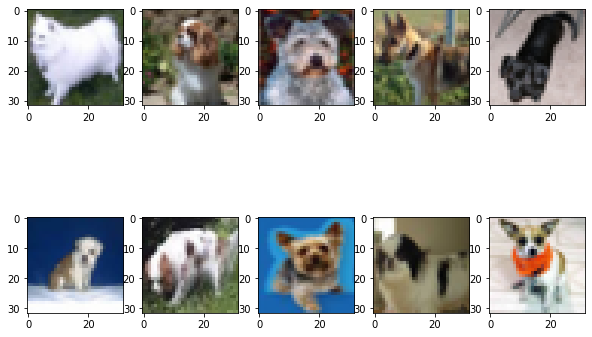

In [ ]:
f, axarr = plt.subplots(2,5, figsize = (10, 7)) 
for i in range(len(sample_images)):
    axarr[i//5, i%5].imshow(sample_images[i][:,:,::-1])

In [ ]:
data_paths = random.sample(all_paths, sample_size)

In [ ]:
x = []
y = []
for path in data_paths:
  img = cv2.imread(data_path + path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) /255
  x.append(np.asarray(img).astype('float32'))

In [ ]:
# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.zeros((len(x))) , test_size=0.3 )

x_train = np.reshape(train_x, newshape=(train_x.shape[0], np.prod(train_x.shape[1:])))
x_test = np.reshape(train_x, newshape=(train_x.shape[0], np.prod(train_x.shape[1:])))

In [ ]:
# Encoder
x = tensorflow.keras.layers.Input(shape=(x_train[0].shape[0]), name="encoder_input")

encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=512, name="encoder_dense_1")(x)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=264, name="encoder_dense_2")(encoder_activ_layer1)
encoder_output = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_2")(encoder_dense_layer2)

# encoder_dense_layer3 = tensorflow.keras.layers.Dense(units=128, name="encoder_dense_3")(encoder_activ_layer2)
# encoder_output = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_3")(encoder_dense_layer3)

# encoder_dense_layer4 = tensorflow.keras.layers.Dense(units=64, name="encoder_dense_4")(encoder_activ_layer3)
# encoder_output = tensorflow.keras.layers.LeakyReLU(name="encoder_output")(encoder_dense_layer4)

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")
encoder.summary()

# Decoder
decoder_input = tensorflow.keras.layers.Input(shape=(264), name="decoder_input")

# decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=128, name="decoder_dense_1")(decoder_input)
# decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

# decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=264, name="decoder_dense_2")(decoder_input)
# decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_dense_layer2)

decoder_dense_layer3 = tensorflow.keras.layers.Dense(units=512, name="decoder_dense_3")(decoder_input)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_dense_layer3)

decoder_dense_layer4 = tensorflow.keras.layers.Dense(units=x_train[0].shape[0], name="decoder_dense_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer4)

decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()


Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 1024)]            0         
                                                                 
 encoder_dense_1 (Dense)     (None, 512)               524800    
                                                                 
 encoder_leakyrelu_1 (LeakyR  (None, 512)              0         
 eLU)                                                            
                                                                 
 encoder_dense_2 (Dense)     (None, 264)               135432    
                                                                 
 encoder_leakyrelu_2 (LeakyR  (None, 264)              0         
 eLU)                                                            
                                                                 
Total params: 660,232
Trainable params: 660,232
Non-t

In [ ]:
# Autoencoder
ae_input = tensorflow.keras.layers.Input(shape=(x_train[0].shape[0]), name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = tensorflow.keras.models.Model(ae_input, ae_decoder_output, name="AE")
ae.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 1024)]            0         
                                                                 
 encoder_model (Functional)  (None, 264)               660232    
                                                                 
 decoder_model (Functional)  (None, 1024)              660992    
                                                                 
Total params: 1,321,224
Trainable params: 1,321,224
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# RMSE
def rmse(y_true, y_predict):
    return tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict))

# AE Compilation
ae.compile(loss="mse", optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
ae.fit(x_train, x_train, epochs=200, batch_size=54, shuffle=True, validation_data=(x_test, x_test))

encoded_images = encoder.predict(x_train)
decoded_images = decoder.predict(encoded_images)
decoded_images_orig = np.reshape(decoded_images, newshape=(decoded_images.shape[0], 32, 32))

Epoch 1/200
33/33 [==============================] - 1s 15ms/step - loss: 0.0695 - val_loss: 0.0363
Epoch 2/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0311 - val_loss: 0.0266
Epoch 3/200
33/33 [==============================] - 0s 9ms/step - loss: 0.0244 - val_loss: 0.0224
Epoch 4/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0207 - val_loss: 0.0191
Epoch 5/200
33/33 [==============================] - 0s 8ms/step - loss: 0.0180 - val_loss: 0.0167
Epoch 6/200
33/33 [==============================] - 0s 8ms/step - loss: 0.0162 - val_loss: 0.0154
Epoch 7/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0148 - val_loss: 0.0140
Epoch 8/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0137 - val_loss: 0.0131
Epoch 9/200
33/33 [==============================] - 0s 7ms/step - loss: 0.0129 - val_loss: 0.0123
Epoch 10/200
33/33 [==============================] - 0s 7ms/step - loss: 0.0121 - val_loss: 0.0119
Epoc

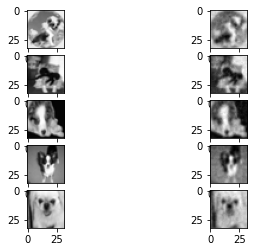

In [ ]:
num_images_to_show = 5
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*2 + 1
    rand_ind = np.random.randint(low=0, high=x_train.shape[0])
    plt.subplot(num_images_to_show, 2, plot_ind)
    plt.imshow(x_train[rand_ind].reshape(32,32), cmap="gray")
    plt.subplot(num_images_to_show, 2, plot_ind+1)
    plt.imshow(decoded_images_orig[rand_ind].reshape(32,32), cmap="gray")